In [106]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from matplotlib import pyplot as plt
from IPython.core.debugger import set_trace
import random
from IPython.display import Image
import torchaudio
import librosa
import matplotlib.pyplot as plt
import librosa.display
import glob
import os.path
import IPython
import random
 

In [107]:
filenames = glob.glob("/home/kchow/SpeechVAE/data/lisa/data/timit/raw/TIMIT/TRAIN/DR1/FCJF0/*.WAV")
spectrogram_clips = []
mel_spectrogram_clips = []
for f in filenames: 
    y, sr = librosa.load(f)
    print(f, len(y))
    D = np.abs(librosa.stft(y))**2
    D = D[:1024,:93]
    S = librosa.feature.melspectrogram(S=D)
    S = S[:128,:93]
    if np.shape(D)[0] != 1024 or np.shape(D)[1] != 93 or np.shape(S)[0] != 128 or np.shape(S)[1] != 93:
        continue
    spectrogram_clips.append(D)
    mel_spectrogram_clips.append(S)

/home/kchow/SpeechVAE/data/lisa/data/timit/raw/TIMIT/TRAIN/DR1/FCJF0/SA2.WAV 47558
/home/kchow/SpeechVAE/data/lisa/data/timit/raw/TIMIT/TRAIN/DR1/FCJF0/SA1.WAV 64493
/home/kchow/SpeechVAE/data/lisa/data/timit/raw/TIMIT/TRAIN/DR1/FCJF0/SX37.WAV 49958
/home/kchow/SpeechVAE/data/lisa/data/timit/raw/TIMIT/TRAIN/DR1/FCJF0/SX307.WAV 31894
/home/kchow/SpeechVAE/data/lisa/data/timit/raw/TIMIT/TRAIN/DR1/FCJF0/SX127.WAV 34011
/home/kchow/SpeechVAE/data/lisa/data/timit/raw/TIMIT/TRAIN/DR1/FCJF0/SI648.WAV 79733
/home/kchow/SpeechVAE/data/lisa/data/timit/raw/TIMIT/TRAIN/DR1/FCJF0/SX397.WAV 54051
/home/kchow/SpeechVAE/data/lisa/data/timit/raw/TIMIT/TRAIN/DR1/FCJF0/SI1027.WAV 68163
/home/kchow/SpeechVAE/data/lisa/data/timit/raw/TIMIT/TRAIN/DR1/FCJF0/SI1657.WAV 62658
/home/kchow/SpeechVAE/data/lisa/data/timit/raw/TIMIT/TRAIN/DR1/FCJF0/SX217.WAV 38245


In [25]:
np.shape(mel_spectrogram_clips[0])

(7, 128, 93)

In [108]:
time_steps = 93
freq_filters = 1024 #if spectrogram
batch_size = 7
epochs = 100
no_cuda = False
seed = 1
beta = 0
log_interval = 1000
cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
loss_function_type = 'Beta' # [DIP-VAE1, 'DIP-VAE2, Beta']
latent_dimensions = 128
fc_dimensions = 512
torch.manual_seed
device = torch.device("cuda" if cuda else "cpu")

In [135]:
variable = 44
class SpeechVAE(nn.Module):
    def __init__(self):
        super(SpeechVAE, self).__init__()
        # in horizontal mode 
        self.conv1 = nn.Conv1d(1, 64, kernel_size=freq_filters, stride=freq_filters)
        #self.conv1 = nn.Conv1d(1, 64, kernel_size=time_steps, stride=time_steps)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1)
        
        self.mu_i = nn.Linear(fc_dimensions, latent_dimensions)
        self.var_i = nn.Linear(fc_dimensions, latent_dimensions)
        
        self.fc1 = nn.Linear(256*variable, fc_dimensions)
        self.fc2 = nn.Linear(latent_dimensions, fc_dimensions)
        self.fc3 = nn.Linear(fc_dimensions, 256*variable)
 
        #self.deconv1 = nn.ConvTranspose1d(256, 128, kernel_size=3, stride=2)
        self.deconv1 = nn.ConvTranspose1d(256, 128, kernel_size=3, stride=1) #to get same size, just kernel+1
        self.deconv2 = nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2)
        self.deconv3 = nn.ConvTranspose1d(64, 1, kernel_size=freq_filters, stride=freq_filters)
        #self.deconv3 = nn.ConvTranspose1d(64, 1, kernel_size=time_steps, stride=time_steps)
    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.tanh(self.fc1(x))
        return self.mu_i(x), self.var_i(x)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        z = F.relu(self.fc2(z))
        z = F.relu(self.fc3(z))
        z = z.view(z.size(0), 256, variable)
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.tanh(self.deconv3(z))
        return z
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [121]:
variable = 44
class SpeechAE(nn.Module):
    def __init__(self):
        super(SpeechAE, self).__init__()
        # in horizontal mode 
        self.conv1 = nn.Conv1d(1, 64, kernel_size=freq_filters, stride=freq_filters)
        #self.conv1 = nn.Conv1d(1, 64, kernel_size=time_steps, stride=time_steps)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1)
        
        #self.mu_i = nn.Linear(fc_dimensions, latent_dimensions)
        #self.var_i = nn.Linear(fc_dimensions, latent_dimensions)
        # 22 mel_spec
        self.fc1 = nn.Linear(256*variable, fc_dimensions)
        self.fc2 = nn.Linear(latent_dimensions, fc_dimensions)
        self.fc3 = nn.Linear(fc_dimensions, 256*variable)
 
        #self.deconv1 = nn.ConvTranspose1d(256, 128, kernel_size=3, stride=2)
        self.deconv1 = nn.ConvTranspose1d(256, 128, kernel_size=3, stride=1) #to get same size, just kernel+1
        self.deconv2 = nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2)
        self.deconv3 = nn.ConvTranspose1d(64, 1, kernel_size=freq_filters, stride=freq_filters)
        #self.deconv3 = nn.ConvTranspose1d(64, 1, kernel_size=time_steps, stride=time_steps)
    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        #print("encoder", x.size())
        x = x.view(x.size(0), -1)
        x = F.tanh(self.fc1(x))
        return x
        #return self.mu_i(x), self.var_i(x)
    
    def decode(self, z):
        
        z = F.relu(self.fc3(z))
        z = z.view(z.size(0), 256, variable)
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.tanh(self.deconv3(z))
        return z
    
    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)


In [127]:
model = SpeechAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#optimizer = optim.SGD(model.parameters(), lr=1e-3)
average_losses = []

def loss_function(recon_x, x):
    MSE = F.mse_loss(recon_x, x)
    return MSE 

# code from https://stackoverflow.com/questions/8290397/how-to-split-an-iterable-in-constant-size-chunks
def data_batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def train(epoch):
    model.train()
    train_loss = 0
    subset_data = spectrogram_clips[:1]
    random.shuffle(subset_data)
    # shuffle subset
    for data in data_batch(subset_data, batch_size):
        # update this to use a larger batch size 
        data = np.array(data)
        # data columns not consistent
        #data = data[:freq_filters,:time_steps]
        #if np.shape(data)[0] != freq_filters or np.shape(data)[1] != time_steps:
            #continue
        data = torch.from_numpy(data)
        #set_trace()
        # how data is set up here MATTERS. Double check with patrick 
        #set_trace()
        data = torch.transpose(data, 1, 2)
        data = data.contiguous().view(data.size(0), -1, freq_filters*time_steps)
        data = data.to(device, dtype=torch.float)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data) #/data.size(0)
        loss.backward()
        #use clip here 
        #clip_gradient = 2
        #nn.utils.clip_grad_norm_(model.parameters(), clip_gradient)
        #set_trace()
        train_loss += loss.item()
        optimizer.step()
        print(epoch, loss.item())
    average_loss = train_loss #/ len(subset_data)
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, average_loss))#len(mel_spectrogram_clips)))
    average_losses.append(average_loss)

def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    

In [140]:
model = SpeechVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#optimizer = optim.SGD(model.parameters(), lr=1e-3)
average_losses = [] 

def loss_function(recon_x, x, mu, logvar):
    if loss_function_type == 'DIP-VAE1':
        return DIP_1_loss_function(recon_x, x, mu, logvar)
    elif loss_function_type == 'DIP-VAE2':
        return DIP_2_loss_function(recon_x, x, mu, logvar)
    elif loss_function_type == 'Beta':
        return beta_loss_function(recon_x, x, mu, logvar)

def beta_loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + (beta*(KLD)/recon_x.size(0))

# code from https://stackoverflow.com/questions/8290397/how-to-split-an-iterable-in-constant-size-chunks
def data_batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def train(epoch):
    model.train()
    train_loss = 0
    subset_data = spectrogram_clips[:8]
    random.shuffle(subset_data)
    # shuffle subset
    for data in data_batch(subset_data, batch_size):
        # update this to use a larger batch size 
        data = np.array(data)
        data = torch.from_numpy(data)
        data = torch.transpose(data, 1, 2)
        data = data.contiguous().view(data.size(0), -1, freq_filters*time_steps)
        data = data.to(device, dtype=torch.float)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar) #/data.size(0)
        loss.backward()
        #use clip here 
        #clip_gradient = 2
        #nn.utils.clip_grad_norm_(model.parameters(), clip_gradient)
        #set_trace()
        train_loss += loss.item()
        optimizer.step()
        print(epoch, loss.item())
    average_loss = train_loss #/ len(subset_data)
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, average_loss))#len(mel_spectrogram_clips)))
    average_losses.append(average_loss)

def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    

1 2.21126294136
====> Epoch: 1 Average loss: 2.2113
2 2.21102333069
====> Epoch: 2 Average loss: 2.2110
3 2.21064281464
====> Epoch: 3 Average loss: 2.2106
4 2.20993876457
====> Epoch: 4 Average loss: 2.2099
5 2.20831918716
====> Epoch: 5 Average loss: 2.2083
6 2.20359992981
====> Epoch: 6 Average loss: 2.2036
7 2.19184660912
====> Epoch: 7 Average loss: 2.1918
8 2.17956566811
====> Epoch: 8 Average loss: 2.1796
9 2.17496228218
====> Epoch: 9 Average loss: 2.1750
10 2.16603779793
====> Epoch: 10 Average loss: 2.1660
11 2.1618335247
====> Epoch: 11 Average loss: 2.1618
12 2.1609711647
====> Epoch: 12 Average loss: 2.1610
13 2.16073179245
====> Epoch: 13 Average loss: 2.1607
14 2.15979266167
====> Epoch: 14 Average loss: 2.1598
15 2.15950250626
====> Epoch: 15 Average loss: 2.1595
16 2.15985369682
====> Epoch: 16 Average loss: 2.1599
17 2.15876078606
====> Epoch: 17 Average loss: 2.1588
18 2.15789532661
====> Epoch: 18 Average loss: 2.1579
19 2.15683937073
====> Epoch: 19 Average loss: 2

163 2.13045310974
====> Epoch: 163 Average loss: 2.1305
164 2.13041377068
====> Epoch: 164 Average loss: 2.1304
165 2.13035964966
====> Epoch: 165 Average loss: 2.1304
166 2.13030576706
====> Epoch: 166 Average loss: 2.1303
167 2.13025760651
====> Epoch: 167 Average loss: 2.1303
168 2.13021802902
====> Epoch: 168 Average loss: 2.1302
169 2.13017296791
====> Epoch: 169 Average loss: 2.1302
170 2.13012266159
====> Epoch: 170 Average loss: 2.1301
171 2.13008928299
====> Epoch: 171 Average loss: 2.1301
172 2.13005614281
====> Epoch: 172 Average loss: 2.1301
173 2.13000631332
====> Epoch: 173 Average loss: 2.1300
174 2.12996768951
====> Epoch: 174 Average loss: 2.1300
175 2.1299469471
====> Epoch: 175 Average loss: 2.1299
176 2.12993001938
====> Epoch: 176 Average loss: 2.1299
177 2.12989401817
====> Epoch: 177 Average loss: 2.1299
178 2.12985682487
====> Epoch: 178 Average loss: 2.1299
179 2.12980413437
====> Epoch: 179 Average loss: 2.1298
180 2.12978339195
====> Epoch: 180 Average loss: 

318 2.12752938271
====> Epoch: 318 Average loss: 2.1275
319 2.12752437592
====> Epoch: 319 Average loss: 2.1275
320 2.12752199173
====> Epoch: 320 Average loss: 2.1275
321 2.12750673294
====> Epoch: 321 Average loss: 2.1275
322 2.12749099731
====> Epoch: 322 Average loss: 2.1275
323 2.12748503685
====> Epoch: 323 Average loss: 2.1275
324 2.12749361992
====> Epoch: 324 Average loss: 2.1275
325 2.12749671936
====> Epoch: 325 Average loss: 2.1275
326 2.12748646736
====> Epoch: 326 Average loss: 2.1275
327 2.12748146057
====> Epoch: 327 Average loss: 2.1275
328 2.12748622894
====> Epoch: 328 Average loss: 2.1275
329 2.12750101089
====> Epoch: 329 Average loss: 2.1275
330 2.12747430801
====> Epoch: 330 Average loss: 2.1275
331 2.12746119499
====> Epoch: 331 Average loss: 2.1275
332 2.12745165825
====> Epoch: 332 Average loss: 2.1275
333 2.12743830681
====> Epoch: 333 Average loss: 2.1274
334 2.12742996216
====> Epoch: 334 Average loss: 2.1274
335 2.12743496895
====> Epoch: 335 Average loss:

473 2.12688612938
====> Epoch: 473 Average loss: 2.1269
474 2.12686610222
====> Epoch: 474 Average loss: 2.1269
475 2.12685275078
====> Epoch: 475 Average loss: 2.1269
476 2.12684082985
====> Epoch: 476 Average loss: 2.1268
477 2.12684369087
====> Epoch: 477 Average loss: 2.1268
478 2.12684321404
====> Epoch: 478 Average loss: 2.1268
479 2.12684750557
====> Epoch: 479 Average loss: 2.1268
480 2.1268389225
====> Epoch: 480 Average loss: 2.1268
481 2.12682318687
====> Epoch: 481 Average loss: 2.1268
482 2.12681221962
====> Epoch: 482 Average loss: 2.1268
483 2.12681627274
====> Epoch: 483 Average loss: 2.1268
484 2.12680745125
====> Epoch: 484 Average loss: 2.1268
485 2.1267952919
====> Epoch: 485 Average loss: 2.1268
486 2.12679433823
====> Epoch: 486 Average loss: 2.1268
487 2.12679553032
====> Epoch: 487 Average loss: 2.1268
488 2.12679290771
====> Epoch: 488 Average loss: 2.1268
489 2.12679100037
====> Epoch: 489 Average loss: 2.1268
490 2.12678956985
====> Epoch: 490 Average loss: 2

632 2.12650775909
====> Epoch: 632 Average loss: 2.1265
633 2.12649059296
====> Epoch: 633 Average loss: 2.1265
634 2.12647414207
====> Epoch: 634 Average loss: 2.1265
635 2.12646079063
====> Epoch: 635 Average loss: 2.1265
636 2.12646269798
====> Epoch: 636 Average loss: 2.1265
637 2.12647509575
====> Epoch: 637 Average loss: 2.1265
638 2.12649512291
====> Epoch: 638 Average loss: 2.1265
639 2.12649083138
====> Epoch: 639 Average loss: 2.1265
640 2.12647294998
====> Epoch: 640 Average loss: 2.1265
641 2.12645125389
====> Epoch: 641 Average loss: 2.1265
642 2.12643885612
====> Epoch: 642 Average loss: 2.1264
643 2.1264424324
====> Epoch: 643 Average loss: 2.1264
644 2.12646245956
====> Epoch: 644 Average loss: 2.1265
645 2.12648010254
====> Epoch: 645 Average loss: 2.1265
646 2.12647223473
====> Epoch: 646 Average loss: 2.1265
647 2.1264526844
====> Epoch: 647 Average loss: 2.1265
648 2.12643027306
====> Epoch: 648 Average loss: 2.1264
649 2.12642097473
====> Epoch: 649 Average loss: 2

788 2.12632203102
====> Epoch: 788 Average loss: 2.1263
789 2.12627959251
====> Epoch: 789 Average loss: 2.1263
790 2.12624645233
====> Epoch: 790 Average loss: 2.1262
791 2.1262447834
====> Epoch: 791 Average loss: 2.1262
792 2.12626552582
====> Epoch: 792 Average loss: 2.1263
793 2.12628698349
====> Epoch: 793 Average loss: 2.1263
794 2.12628793716
====> Epoch: 794 Average loss: 2.1263
795 2.12625646591
====> Epoch: 795 Average loss: 2.1263
796 2.1262345314
====> Epoch: 796 Average loss: 2.1262
797 2.12622284889
====> Epoch: 797 Average loss: 2.1262
798 2.12622904778
====> Epoch: 798 Average loss: 2.1262
799 2.12624144554
====> Epoch: 799 Average loss: 2.1262
800 2.12625169754
====> Epoch: 800 Average loss: 2.1263
801 2.1262409687
====> Epoch: 801 Average loss: 2.1262
802 2.12622928619
====> Epoch: 802 Average loss: 2.1262
803 2.12621688843
====> Epoch: 803 Average loss: 2.1262
804 2.12621498108
====> Epoch: 804 Average loss: 2.1262
805 2.1262216568
====> Epoch: 805 Average loss: 2.1

947 2.12613368034
====> Epoch: 947 Average loss: 2.1261
948 2.12613320351
====> Epoch: 948 Average loss: 2.1261
949 2.12612748146
====> Epoch: 949 Average loss: 2.1261
950 2.12612247467
====> Epoch: 950 Average loss: 2.1261
951 2.12612056732
====> Epoch: 951 Average loss: 2.1261
952 2.12612318993
====> Epoch: 952 Average loss: 2.1261
953 2.12612271309
====> Epoch: 953 Average loss: 2.1261
954 2.12612628937
====> Epoch: 954 Average loss: 2.1261
955 2.12612485886
====> Epoch: 955 Average loss: 2.1261
956 2.12612366676
====> Epoch: 956 Average loss: 2.1261
957 2.1261241436
====> Epoch: 957 Average loss: 2.1261
958 2.12612533569
====> Epoch: 958 Average loss: 2.1261
959 2.1261279583
====> Epoch: 959 Average loss: 2.1261
960 2.12612891197
====> Epoch: 960 Average loss: 2.1261
961 2.12612962723
====> Epoch: 961 Average loss: 2.1261
962 2.12613368034
====> Epoch: 962 Average loss: 2.1261
963 2.12614488602
====> Epoch: 963 Average loss: 2.1261
964 2.12615561485
====> Epoch: 964 Average loss: 2

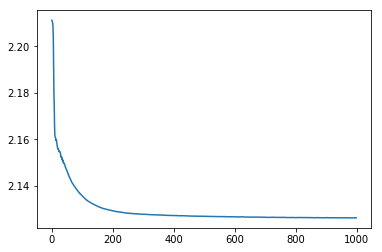

In [141]:
for epoch in range(1, 1000):
    train(epoch)
plt.figure(1)
plt.plot(average_losses)
plt.show()

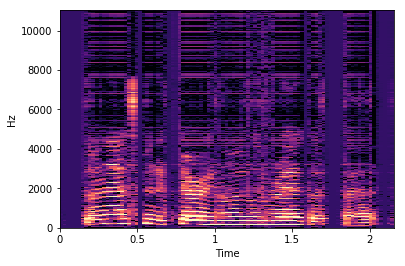

In [129]:
# AE
with torch.no_grad():
    sample = spectrogram_clips[0]
    sample = torch.from_numpy(sample)
    sample = torch.transpose(sample, 0, 1)
    sample = sample.contiguous().view(1, -1, freq_filters*time_steps)
    sample = sample.to(device, dtype=torch.float)
    z = model.encode(sample)
    sample = model.decode(z).cpu()
    sample = sample.view(1, time_steps, freq_filters)
    sample = torch.transpose(sample, 1, 2)
    fft_size = 512
    step_size = 64
    #test_sample = mel_to_spectrogram(gogo, get_filterbanks(), 4, 10)
    #recovered_audio_orig = invert_pretty_spectrogram(sample[0], fft_size = fft_size, step_size = step_size, log = True, n_iter = 10)
    
    #import IPython
    librosa.display.specshow(librosa.amplitude_to_db(sample[0], ref=np.max), y_axis='linear', x_axis='time')
    #librosa.display.specshow(librosa.power_to_db(sample[0], ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
y_out = librosa.istft(sample[0].numpy(), length=47558)
IPython.display.Audio(data=y_out, rate=22050)

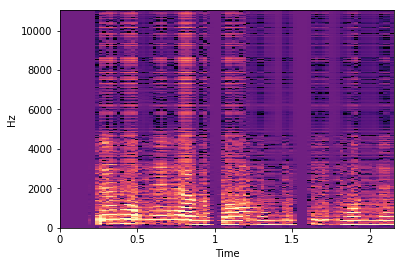

In [144]:
# VAE
with torch.no_grad():
    sample = spectrogram_clips[3]
    sample = torch.from_numpy(sample)
    sample = torch.transpose(sample, 0, 1)
    sample = sample.contiguous().view(1, -1, freq_filters*time_steps)
    sample = sample.to(device, dtype=torch.float)
    mu, logvar = model.encode(sample)
    z = model.reparameterize(mu, logvar)
    #sample = torch.randn(1, latent_dimensions).to(device)
    sample = model.decode(z).cpu()
    sample = sample.view(1, time_steps, freq_filters)
    sample = torch.transpose(sample, 1, 2)
    fft_size = 512
    step_size = 64
    #test_sample = mel_to_spectrogram(gogo, get_filterbanks(), 4, 10)
    #recovered_audio_orig = invert_pretty_spectrogram(sample[0], fft_size = fft_size, step_size = step_size, log = True, n_iter = 10)
    
    #import IPython
    librosa.display.specshow(librosa.amplitude_to_db(sample[0], ref=np.max), y_axis='linear', x_axis='time')
    #librosa.display.specshow(librosa.power_to_db(sample[0], ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
y_out = librosa.istft(sample[0].numpy(), length=47558)
IPython.display.Audio(data=y_out, rate=22050)

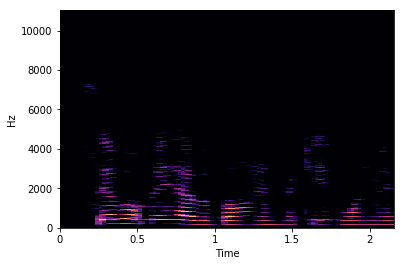

In [145]:
librosa.display.specshow(librosa.amplitude_to_db(spectrogram_clips[3], ref=np.max), y_axis='linear', x_axis='time')
#librosa.display.specshow(librosa.power_to_db(mel_spectrogram_clips[0], ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
y_out = librosa.istft(spectrogram_clips[1], length=47558)
IPython.display.Audio(data=y_out, rate=22050)

In [4]:
IPython.display.Audio("/home/kchow/datasets/clips/918.mp3")